In [1]:
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import argparse
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
import os
import random
import copy
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from torch.optim.lr_scheduler import _LRScheduler
import csv
import tensorflow_probability as tfp
import warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"

def seed_everything(seed=12):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed) 
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

parser = argparse.ArgumentParser(description='Wikiart Training')
parser.add_argument('--split', action='store_true', help='split or full')
parser.add_argument('--lr', default=2e-5, type=float, help='learning rate')
parser.add_argument('--lr_schedule', default=0, type=int, help='lr scheduler')
parser.add_argument('--batch_size', default=32, type=int, help='batch size')
parser.add_argument('--test_batch_size', default=64, type=int, help='batch size')
parser.add_argument('--num_epoch', default=50, type=int, help='epoch number')
parser.add_argument('--num_classes', type=int, default=6, help='number classes')
parser.add_argument('--max_length', type=int, default=30, help='max length')
parser.add_argument('-warm', type=int, default=1, help='warm up training phase')
parser.add_argument('--smoothing', default = 0.1, type=float, help='ls smoothing')
parser.add_argument('--mcls', action='store_true', help='mcls or ls')
parser.add_argument('--mcls_weight', default = 300, type=float, help='mcls weight')
parser.add_argument('--hcls', action='store_true', help='hcls or ls')
parser.add_argument('--hcls_weight', default = 300, type=float, help='hcls_weight')
#parameters for curriculum learning
parser.add_argument('--nocl', action='store_true', help='cl or not')
parser.add_argument('--mccl', action='store_true', help='mccl or not')
parser.add_argument('--hccl', action='store_true', help='hccl or not')
parser.add_argument('--init_ratio', default = 0.75, type=float, help='initial prob')
parser.add_argument('--beta', default = 0.75, type=float, help='initial prob')
parser.add_argument('--end_epoch',default = 30, type=int, help='epoch iid')
args = parser.parse_args(args=[])


In [2]:
class WarmUpLR(_LRScheduler):
    """
        optimizer: optimzier(e.g. SGD)
        total_iters: totoal_iters of warmup phase
    """
    def __init__(self, optimizer, total_iters, last_epoch=-1):

        self.total_iters = total_iters
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [base_lr * self.last_epoch / (self.total_iters + 1e-8) for base_lr in self.base_lrs]


def write_csv(filename, data):
    with open(filename, 'a') as outfile:
        writer = csv.writer(outfile)
        writer.writerow(data)


class CELossWith_MHCLS(torch.nn.Module):
    
    def __init__(self, classes=1000, smoothing=0.1, ignore_index=-1, confls=None, confls_weight=None):
        super(CELossWith_MHCLS, self).__init__()
        self.smoothing = smoothing if confls is None else smoothing + confls/confls_weight
        self.complement = 1.0 - smoothing
        self.cls = classes
        self.log_softmax = torch.nn.LogSoftmax(dim=1)
        self.ignore_index = ignore_index

    def forward(self, logits, target, ):
        with torch.no_grad():
            oh_labels = F.one_hot(target.to(torch.int64), num_classes = self.cls).contiguous()
            smoothen_ohlabel = oh_labels * self.complement  + self.smoothing / self.cls
            smoothen_ohlabel = (smoothen_ohlabel/smoothen_ohlabel.sum(1)[:,None]) # to normalise the distr into sum 1
        
        logs = self.log_softmax(logits[target!=self.ignore_index])
        return -torch.sum(logs * smoothen_ohlabel[target!=self.ignore_index], dim=1).mean()


def get_threshold_confidence(model_rank, trainloader_rank, init_ratio=0.80):  
    conf_list_all = []
    correct = 0
    total = 0
    with torch.no_grad():
        for d in trainloader_rank:
            inputs = d["input_ids"].squeeze(1).to(device)
            attention_mask = d["mask"].squeeze(1).to(device)
            targets = d["targets"].to(device)
            outputs = model_rank(input_ids=inputs,attention_mask=attention_mask).logits
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            conf = F.softmax(outputs, dim=1)
            conf_list = [conf_each[int(targets[i])] for i, conf_each in enumerate(conf)]
            conf_list_all.extend(torch.tensor(conf_list))

        print('ranked model acc:',correct / total)
    conf_list_all = torch.tensor(conf_list_all)
    sample_total = len(conf_list_all)
    for mu in np.arange(1, 0, -0.001):
        sample_mu = len(conf_list_all[conf_list_all>mu])
        ratio = sample_mu / sample_total
        if ratio >= init_ratio:
            break

    return mu, conf_list_all

def get_threshold_scaler_ad_sample(ad, init_ratio=0.80):     
    ad_std_list = []
    for i in range (len(ad)):
        ad_std = np.std(ad[i])
        ad_std_list.append(ad_std)
    ad_std_list = np.array(ad_std_list)
    std_norm_list = []
    
    for k in range (len(ad_std_list)):
        norm_std = (ad_std_list[k] - min(ad_std_list)) / (max(ad_std_list)-min(ad_std_list))
        std_norm_list.append(norm_std)

    std_norm_list = np.array(std_norm_list)
    
    conf_list_all = torch.tensor(std_norm_list)
    
    sample_total = len(conf_list_all)
    for mu in np.arange(1, 0, -0.001):
        sample_mu = len(conf_list_all[conf_list_all>mu])
        ratio = sample_mu / sample_total
        if ratio >= init_ratio:
            break

    return mu, conf_list_all


def train(model, trainloader, criterion, optimizer, epoch, scheduler, args):
    model.train()
    for d in trainloader:
        inputs = d["input_ids"].squeeze(1).to(device)
        attention_mask = d["mask"].squeeze(1).to(device)
        targets = d["targets"].to(device)
        # print("target",targets[:10] )
        conf_list = d['conf'].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids=inputs,attention_mask=attention_mask).logits
        loss = criterion(outputs[conf_list>=args.mu], targets[conf_list>=args.mu])
        # print("loss", loss.item())
        loss.backward()
        optimizer.step()
        scheduler.step()

        
        
def test(model, testloader):
    model.eval()
    correct = 0
    total = 0
    logits_list = []
    labels_list = []
    with torch.no_grad():

        for d in testloader:
            inputs = d["input_ids"].squeeze(1).to(device)
            attention_mask = d["mask"].squeeze(1).to(device)
            targets = d["targets"].to(device)
            outputs = model(input_ids=inputs,attention_mask=attention_mask).logits
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            logits_list.append(outputs)
            labels_list.append(targets)

        logits = torch.cat(logits_list).cpu().numpy()
        labels = torch.cat(labels_list).cpu().numpy()

        ece = tfp.stats.expected_calibration_error(num_bins=10, logits=logits, labels_true=labels.astype(int), labels_predicted=np.argmax(logits,1))
    return correct / total, ece

class Wikiart_Dataset_split(Dataset):

    def __init__(self, title, targets, tokenizer, max_len, mh_confidence=None, istrain = True):
        self.title = title
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.istrain = istrain
        if self.istrain:
            self.mhc = mh_confidence
            self.title = self.title[:2500]
            self.targets = self.targets[:2500]
        else:
            self.title = self.title[2500:]
            self.targets = self.targets[2500:]
  
    def __len__(self):
        return len(self.title)
  
    def __getitem__(self, item):
        input = str(self.title[item])
        targets = self.targets[item]

        encoding = self.tokenizer.encode_plus(
          input,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=True,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt',)
        ids = encoding['input_ids']
        mask = encoding['attention_mask']
        if self.istrain:
            return {
            'input_ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.targets[item], dtype=torch.float),
            'conf':torch.tensor(self.mhc[item], dtype=torch.float)}
        else:
            return {
            'input_ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.targets[item], dtype=torch.float)}

class Wikiart_Dataset(Dataset):

    def __init__(self, title, targets, tokenizer, max_len, mh_confidence=None, istrain = True):
        self.title = title
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.istrain = istrain
        if self.istrain:
            self.mhc = mh_confidence
  
    def __len__(self):
        return len(self.title)
  
    def __getitem__(self, item):
        input = str(self.title[item])
        targets = self.targets[item]

        encoding = self.tokenizer.encode_plus(
          input,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=True,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt',)
        ids = encoding['input_ids']
        mask = encoding['attention_mask']
        if self.istrain:
            return {
            'input_ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.targets[item], dtype=torch.float),
            'conf':torch.tensor(self.mhc[item], dtype=torch.float)}
        else:
            return {
            'input_ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.targets[item], dtype=torch.float)}


def get_ad(ad):
    all_ad = []
    for i in range(len(ad)):
        per_ad = np.array(ad[i][2:-2].split(' '), dtype = np.float32)
        all_ad.append(per_ad)
    all_ad = np.array(all_ad)
    return all_ad


In [3]:
seed_everything()
conf_score = torch.tensor([0.8871, 0.8848, 0.8912, 0.8898, 0.7549, 0.8843]).to(device)

warnings.filterwarnings("ignore")
transformers.logging.set_verbosity_error()
#standard wikiart dataloader
df = pd.read_csv("processed_wikiart_title.csv")
df_train, df_test = train_test_split(df, test_size=0.2, random_state=12)
PRE_TRAINED_MODEL_NAME = 'distilbert-base-uncased'
tokenizer=AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=args.num_classes).cuda()
model.load_state_dict(torch.load('ckpt_text/best_model_wikiart_split0_mcls0_mccl0_hcls1_hccl1.pth.tar'))

model_rank = copy.deepcopy(model).to(device)
model_rank.load_state_dict(torch.load('ckpt_split/best_model_wikiart_split1_mcls0_mccl0_mcls0_mccl0.pth.tar'))
model_rank.eval()
train_set = Wikiart_Dataset(title=df_train.Title.to_numpy(),targets=df_train.label.to_numpy(),
                        tokenizer=tokenizer,max_len=args.max_length, mh_confidence=None, istrain = False)
train_loader_rank = DataLoader(train_set, args.batch_size, shuffle =False, num_workers=2)
args.mu, mhconf_list_all = get_threshold_confidence(model_rank, train_loader_rank, init_ratio=args.init_ratio)

train_set = Wikiart_Dataset(title=df_train.Title.to_numpy(),targets=df_train.label.to_numpy(),
                            tokenizer=tokenizer,max_len=args.max_length, mh_confidence= mhconf_list_all, istrain = True)
test_set = Wikiart_Dataset(title=df_test.Title.to_numpy(),targets=df_test.label.to_numpy(),
                            tokenizer=tokenizer,max_len=args.max_length, mh_confidence= None, istrain = False)

train_loader = DataLoader(train_set, args.batch_size, shuffle =True, num_workers=2)
test_loader = DataLoader(test_set, args.batch_size, shuffle =False, num_workers=2)

optimizer = AdamW(model.parameters(), lr=args.lr, correct_bias=False)
total_steps = len(train_loader) * args.num_epoch

scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,num_training_steps=total_steps)
criterion = CELossWith_MHCLS(classes=args.num_classes, smoothing=args.smoothing, confls=conf_score, confls_weight=args.mcls_weight)


ranked model acc: 0.8775883069427527


(array([0.        , 0.        , 0.        , 0.        , 0.27442797,
        0.36961025, 0.44158087, 0.49990292, 0.57354071, 0.63724318,
        0.70251449, 0.7680003 , 0.83656253, 0.88219403, 0.        ]),
 array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.43478261, 0.425     , 0.42      , 0.47058824, 0.54098361,
        0.67123288, 0.70469799, 0.79310345, 0.84545455, 0.        ]))

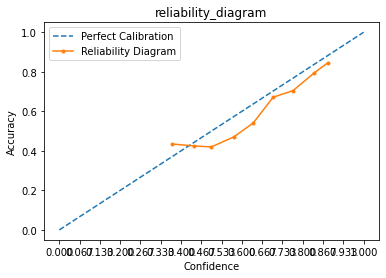

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import f1_score

labels = []
for i in range(len(test_loader.dataset)):
    label = test_loader.dataset[i]['targets']
    labels.append(label)
labels = np.array(labels)

class _ECELoss(nn.Module):
    def __init__(self, n_bins=15):
        """
        n_bins (int): number of confidence interval bins
        """
        super(_ECELoss, self).__init__()
        bin_boundaries = torch.linspace(0, 1, n_bins + 1)
        self.bin_lowers = bin_boundaries[:-1]
        self.bin_uppers = bin_boundaries[1:]

    def forward(self, logits, labels):
        softmaxes = F.softmax(logits, dim=1)
        confidences, predictions = torch.max(softmaxes, 1)
        accuracies = predictions.eq(labels)
        ece = torch.zeros(1, device=logits.device)
        for bin_lower, bin_upper in zip(self.bin_lowers, self.bin_uppers):
            # Calculated |confidence - accuracy| in each bin
            in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
            prop_in_bin = in_bin.float().mean()
            if prop_in_bin.item() > 0:
                accuracy_in_bin = accuracies[in_bin].float().mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

        return ece
def evaluation(model, testing_loader):
    model.eval()
    total_acc = 0
    total_loss = 0
    count = 0
    pred_all = []
    target_all = []
    logits_list, labels_list = [], [] 
    with torch.no_grad():
        for d in testing_loader:
            input_ids = d["input_ids"].squeeze(1).to(device)
            attention_mask = d["mask"].squeeze(1).to(device)
            targets = d["targets"].to(device)
            outputs = model(input_ids=input_ids,attention_mask=attention_mask).logits
            loss_val = criterion(outputs.squeeze(), targets.long())
            predictions = torch.max(outputs, 1)[1].view(targets.size()).data
            pred_all.append(outputs)
            target_all.append(targets)
            
            f1 = f1_score(targets.data.cpu(), predictions.cpu(), average='macro')
            num_corrects = (predictions == targets.data).float().sum()
            acc = 100.0 * num_corrects / args.test_batch_size
            total_acc += acc.item()
            total_loss += loss_val.item()
            count += 1
        logits_all = torch.cat(pred_all).cuda()
        labels_all = torch.cat(target_all).cuda()
    return total_acc/count,f1, logits_all, labels_all
ece_criterion = _ECELoss().to(device)
accuracy,total_f1, logits_all,labels_all = evaluation(model, test_loader)



def ece_eval(preds, targets, n_bins=15, bg_cls = -1):
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    confidences, predictions = np.max(preds,1), np.argmax(preds,1)
    confidences, predictions = confidences[targets>bg_cls], predictions[targets>bg_cls]
    accuracies = (predictions == targets[targets>bg_cls]) 
    Bm, acc, conf = np.zeros(n_bins), np.zeros(n_bins), np.zeros(n_bins)
    ece = 0.0
    bin_idx = 0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = np.logical_and(confidences > bin_lower, confidences <= bin_upper)
        #in_bin = in_bin[targets>backgound_class]
        bin_size = np.sum(in_bin)
        
        Bm[bin_idx] = bin_size
        if bin_size > 0:  
            accuracy_in_bin = np.sum(accuracies[in_bin])
            acc[bin_idx] = accuracy_in_bin / Bm[bin_idx]
            confidence_in_bin = np.sum(confidences[in_bin])
            conf[bin_idx] = confidence_in_bin / Bm[bin_idx]
        bin_idx += 1
        
    ece_all = Bm * np.abs((acc - conf))/ Bm.sum()
    ece = ece_all.sum() 
    return ece, acc, conf, Bm



def get_reliability_diagram(conf_avg, acc_avg, legend=None, leg_idx=0, n_bins=15, fig=2):
    plt.figure(fig)
    plt.plot([0, 1], [0, 1], linestyle='--',label = 'Perfect Calibration')
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(0, 1.1, 1/n_bins))
    plt.title('{}'.format(fig))
    plt.plot(conf_avg[acc_avg>0],acc_avg[acc_avg>0], marker='.', label = legend)
    plt.legend()
    plt.savefig('ece_reliability_diag_{}.png'.format(fig),dpi=300)
    
logits_all =F.softmax(logits_all, dim=1).detach().cpu().numpy()
labels_all =labels_all.detach().cpu().numpy()
ece, acc, conf, Bm = ece_eval(logits_all, labels_all)

get_reliability_diagram(conf, acc, legend='Reliability Diagram', fig='reliability_diagram')
conf,acc